<a href="https://colab.research.google.com/github/MahdiFaourr/MahdiFaourr/blob/main/tumor_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install opendatasets library
!pip install opendatasets

In [ ]:
# Install gradio library
!pip install gradio==3.14.0

In [5]:
# Import necessary libraries and functions
import opendatasets as od
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPooling2D,Input
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision
from keras.callbacks import ModelCheckpoint
import numpy as np
import gradio as gr
from tensorflow.keras.preprocessing import image
from PIL import Image

In [ ]:
# Download the dataset from kaggle
od.download("https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection ")

In [ ]:
SEED=42 #randomseed=42

In [ ]:
# Define the root directories for images with and without tumors
root_dir_1="/content/brain-mri-images-for-brain-tumor-detection /no"
root_dir_2="/content/brain-mri-images-for-brain-tumor-detection /yes"
# Define the root directory for all images
root_dir="/content/brain-mri-images-for-brain-tumor-detection"
# Get a list of filenames for images with no tumor from root_dir_1
no_tumor_images=[file for file in os.listdir(root_dir_1)]
# Get a list of filenames for images with tumors from root_dir_2
with_tumor_images=[file for file in os.listdir(root_dir_2)]
# Split the list of filenames for images with no tumor into training and validation sets
no_tumor_train_images,no_tumor_valid_images=train_test_split(no_tumor_images,test_size=0.2)
# Split the list of filenames for images with tumors into training and validation sets
with_tumor_train_images,with_tumor_valid_images=train_test_split(with_tumor_images,test_size=0.2)

In [ ]:
# Define the classes (categories) for classification
classes = ['no', 'yes']

# Create directories for training and validation sets for the 'no' class
train_dir_no_file = os.path.join(root_dir, "train", classes[0])
# Create the directory if it doesn't exist already
os.makedirs(train_dir_no_file, exist_ok=True)

# Create directories for training and validation sets for the 'yes' class
train_dir_yes_file = os.path.join(root_dir, "train", classes[1])
# Create the directory if it doesn't exist already
os.makedirs(train_dir_yes_file, exist_ok=True)

# Create directories for training and validation sets for the 'no' class
valid_dir_no_file = os.path.join(root_dir, "valid", classes[0])
# Create the directory if it doesn't exist already
os.makedirs(valid_dir_no_file, exist_ok=True)

# Create directories for training and validation sets for the 'yes' class
valid_dir_yes_file = os.path.join(root_dir, "valid", classes[1])
# Create the directory if it doesn't exist already
os.makedirs(valid_dir_yes_file, exist_ok=True)

In [ ]:
# Loop through pairs of filenames from the training sets of images with no tumor and images with tumor
for img, image in zip(no_tumor_train_images, with_tumor_train_images):
    # Define source and destination paths for images with no tumor
    source_path_1 = os.path.join(root_dir_1, img)
    destination_path_1 = os.path.join(train_dir_no_file, img)
    # Move images with no tumor from source to destination
    shutil.move(source_path_1, destination_path_1)

    # Define source and destination paths for images with tumor
    source_path_2 = os.path.join(root_dir_2, image)
    destination_path_2 = os.path.join(train_dir_yes_file, image)
    # Move images with tumor from source to destination
    shutil.move(source_path_2, destination_path_2)


In [ ]:
# Loop through pairs of filenames from the validation sets of images with no tumor and images with tumor
for img, image in zip(no_tumor_valid_images, with_tumor_valid_images):
    # Define source and destination paths for images with no tumor
    source_path_1 = os.path.join(root_dir_1, img)
    destination_path_1 = os.path.join(valid_dir_no_file, img)
    # Move images with no tumor from source to destination
    shutil.move(source_path_1, destination_path_1)

    # Define source and destination paths for images with tumor
    source_path_2 = os.path.join(root_dir_2, image)
    destination_path_2 = os.path.join(valid_dir_yes_file, image)
    # Move images with tumor from source to destination
    shutil.move(source_path_2, destination_path_2)

In [ ]:
# Define the parameters for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=15,  # Rotate images randomly by up to 15 degrees
    width_shift_range=0.1,  # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1,  # Shift images vertically by up to 10% of the height
    shear_range=0.1,  # Shear transformations with a maximum shear intensity of 10%
    zoom_range=0.1,  # Zoom in randomly by up to 10%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,  # Flip images vertically
    fill_mode='nearest'  # Fill missing pixels using the nearest value
)

# Define the directory containing your image data
train_dir = "/content/brain-mri-images-for-brain-tumor-detection/train"
valid_dir= "/content/brain-mri-images-for-brain-tumor-detection/valid"

# Create an ImageDataGenerator for the training data
train_generator =datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode='binary'
)

valid_generator=datagen.flow_from_directory(
    valid_dir,
    batch_size=32,
    class_mode='binary'
)


In [ ]:
# Define input shape
input_shape = (256, 256, 3)  #  Input images are 256x256 RGB images

# Define input layer
inputs = Input(shape=input_shape)

# Convolutional layers
layer_1= Conv2D(6, kernel_size=(3, 3), activation='relu')(inputs)
layer_2 =MaxPooling2D(pool_size=(2, 2))(layer_1)
layer_3 = Conv2D(12, kernel_size=(3, 3), activation='relu')(layer_2)
layer_4 = MaxPooling2D(pool_size=(2, 2))(layer_3)

# Flatten layer
layer_5= Flatten()(layer_4)

# Dense layers
layer_6 = Dense(100, activation='relu')(layer_5)
outputs = Dense(1, activation='sigmoid')(layer_6)  # Output layer with sigmoid activation for binary classification

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',Precision()])

# Print model summary
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 12)      660       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 12)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 46128)             0   

In [ ]:
# Define a checkpoint callback to save the best weights
checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train your model with the callback
history=model.fit(train_generator,validation_data=(valid_generator),epochs=20,batch_size=len(train_generator),callbacks=[checkpoint])

In [ ]:
# Load the best weights into your model
model.load_weights('best_weights.h5')

In [ ]:
# Evaluate the model over valid_generator
model.evaluate(valid_generator)

2/2 [==============================] - 1s 100ms/step - loss: 0.4115 - accuracy: 0.8000 - precision_2: 0.8000


[0.41145434975624084, 0.800000011920929, 0.800000011920929]

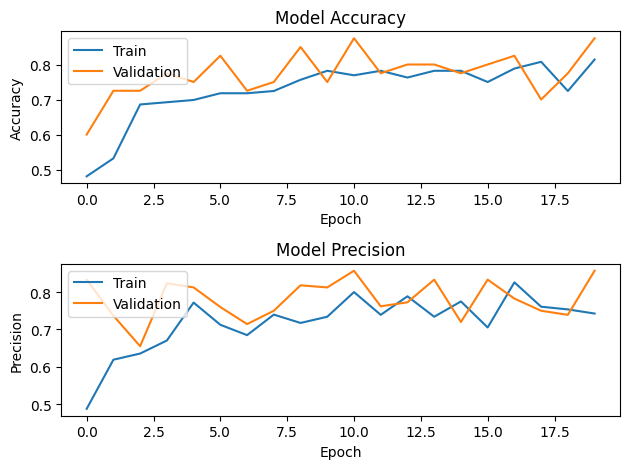

In [ ]:
# `history.history` is a dictionary containing the training and validation metrics
import matplotlib.pyplot as plt
# Plotting accuracy
plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot 1 (top subplot)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting precision
plt.subplot(2, 1, 2)  # 2 rows, 1 column, plot 2 (bottom subplot)
plt.plot(history.history['precision_2'])
plt.plot(history.history['val_precision_2'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Adjust subplot layout to avoid overlap

# Show plot
plt.show()

In [ ]:
# Save the model as an HDF5 file
model.save('brain_tumor_model.h5')

In [15]:
# Define a function to make predictions
def diagnosis(img):
    # Convert Gradio Image object to PIL Image object
    img = Image.fromarray(img.astype('uint8'), 'RGB')

    # Resize the image to match the model's expected input size
    img = img.resize((256, 256))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Expand the dimensions to match the model's expected input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Use the model to predict
    prediction = model.predict(img_array)[0]

    # Check if prediction is positive or negative
    if prediction <= 0.5:
        return 'Tumor presence: negative.'
    else:
        return 'Tumor presence: positive.'

In [ ]:
# Example usage 1
image_path_1="/content/brain-mri-images-for-brain-tumor-detection/valid/no/37 no.jpg"
diagnosis(image_path_1)

1/1 [==============================] - 0s 143ms/step
Tumor presence: negative.


In [ ]:
# Example usage 2
image_path_2="/content/brain-mri-images-for-brain-tumor-detection/valid/yes/Y156.JPG"
diagnosis(image_path_2)

1/1 [==============================] - 0s 37ms/step
 Tumor presenece: positive.


In [ ]:
# Define the input component for the Gradio interface
inputs = gr.inputs.Image(shape=(256, 256))

# Define the output component for the Gradio interface
outputs = gr.outputs.Label()

# Create the Gradio interface
gr.Interface(diagnosis, inputs, outputs, capture_session=True,share=True).launch(debug='True')


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:256: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:196: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `capture_session` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/d

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 50ms/step
